In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from pytorch_pretrained_bert import BertModel, BertTokenizer
from models import BertModelHT

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
# Load pre-trained model tokenizer (vocabulary-multilingual)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

modelHT = BertModelHT.from_pretrained('bert-base-multilingual-cased')
modelHT.eval()

model = BertModel.from_pretrained('bert-base-multilingual-cased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in

In [3]:
DATA_PATH = "/Users/cha/Desktop/Code/nlp-codes/nlp-intent-classification/data/full_dataset/goemotions_1.csv"

df = pd.read_csv(DATA_PATH)
df = df[["text"]].copy()
heavytailed = []
normal = []

for i in tqdm(df.iloc[:2000].index):
    text = df["text"].iloc[i]
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)
    segments_ids = [1] * len(tokenized_text)

    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layersHT, _ = modelHT(tokens_tensor, segments_tensors)
        encoded_layers, _ = model(tokens_tensor, segments_tensors)

    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddingsHT = torch.stack(encoded_layersHT, dim=0)
    token_embeddings = torch.stack(encoded_layers, dim=0)

    # Remove dimension 1, the "batches".
    token_embeddingsHT = torch.squeeze(token_embeddingsHT, dim=1)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # Swap dimensions 0 and 1.
    token_embeddingsHT = token_embeddingsHT.permute(1,0,2)
    token_embeddings = token_embeddings.permute(1,0,2)

    # `encoded_layers` has shape [12 x 1 x 23 x 768]

    # `token_vecs` is a tensor with shape [23 x 768]
    token_vecsHT = encoded_layersHT[11][0]
    token_vecs = encoded_layers[11][0]

    # Calculate the average of all 23 token vectors.
    sentence_embeddingHT = torch.mean(token_vecsHT, dim=0)
    sentence_embedding = torch.mean(token_vecs, dim=0)

    heavytailed.append(sentence_embeddingHT.numpy())
    normal.append(sentence_embedding.numpy())

100%|██████████| 2000/2000 [02:07<00:00, 15.72it/s]


In [4]:
new_df = df[:2000].copy()
new_df["embeddings_heavytailed"] = heavytailed
new_df["embeddings_normal"] = normal
new_df.head()

,text,embeddings_heavytailed,embeddings_normal
0,That game hurt.,"[0.30054873, -0.34403887, 0.49052837, 0.355931...","[0.03866393, -0.3352241, 0.09783534, 0.4107893..."
1,>sexuality shouldn’t be a grouping category I...,"[0.33468005, -0.49715105, 0.89346, 0.4685439, ...","[-0.0925654, -0.40961725, 0.73432565, 0.262471..."
2,"You do right, if you don't care then fuck 'em!","[0.41809124, -0.56398976, 0.5880229, 0.2924358...","[0.025010547, -0.29629883, 0.1804195, 0.364225..."
3,Man I love reddit.,"[0.2544118, -0.30285338, 0.4606152, 0.10065924...","[0.090971045, -0.18047546, 0.5608628, 0.029287..."
4,"[NAME] was nowhere near them, he was by the Fa...","[0.104422264, -0.29959264, 0.5575756, 0.153036...","[-0.24412851, -0.12715612, 0.09654636, 0.20951..."


In [5]:
new_df.to_csv("/Users/cha/Desktop/Code/nlp-codes/nlp-intent-classification/data/full_dataset/goemotions_1_embeddings.csv")

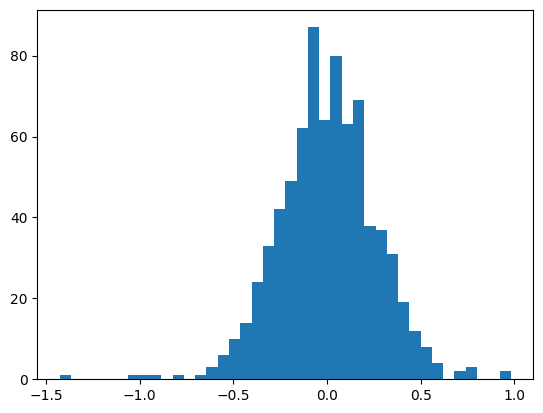

In [13]:
import matplotlib.pyplot as plt

embedding = new_df.iloc[0]["embeddings_normal"]
plt.hist(embedding, bins=40)
plt.show()

In [33]:
new_df["normHT"] = new_df["embeddings_heavytailed"].apply(lambda x: torch.norm(torch.Tensor(x), p=2).item())
new_df["norm"] = new_df["embeddings_normal"].apply(lambda x: torch.norm(torch.Tensor(x), p=2).item())
new_df.head()

,text,embeddings_heavytailed,embeddings_normal,norm,normHT
0,That game hurt.,"[0.30054873, -0.34403887, 0.49052837, 0.355931...","[0.03866393, -0.3352241, 0.09783534, 0.4107893...",7.233641,6.533833
1,>sexuality shouldn’t be a grouping category I...,"[0.33468005, -0.49715105, 0.89346, 0.4685439, ...","[-0.0925654, -0.40961725, 0.73432565, 0.262471...",8.612430,11.777950
2,"You do right, if you don't care then fuck 'em!","[0.41809124, -0.56398976, 0.5880229, 0.2924358...","[0.025010547, -0.29629883, 0.1804195, 0.364225...",9.011077,9.238997
3,Man I love reddit.,"[0.2544118, -0.30285338, 0.4606152, 0.10065924...","[0.090971045, -0.18047546, 0.5608628, 0.029287...",5.851167,6.904801
4,"[NAME] was nowhere near them, he was by the Fa...","[0.104422264, -0.29959264, 0.5575756, 0.153036...","[-0.24412851, -0.12715612, 0.09654636, 0.20951...",7.451855,9.406238


<Axes: >

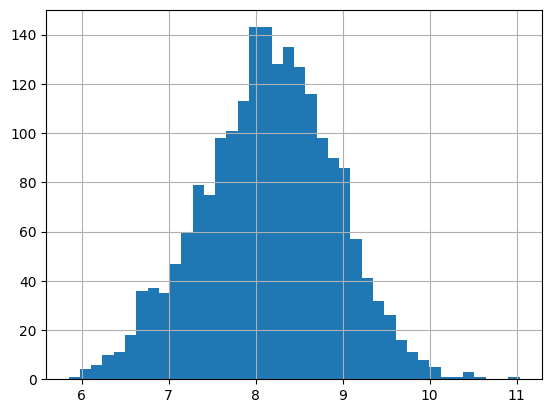

In [34]:
new_df["norm"].hist(bins=40)

<Axes: >

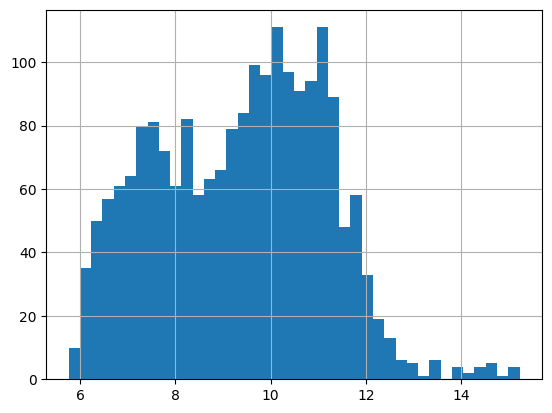

In [35]:
new_df["normHT"].hist(bins=40)